# **Import the Necessary Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Lambda, MultiHeadAttention, Dropout, LayerNormalization, Dense
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

2025-09-03 15:47:47.367814: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756914467.551899      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756914467.604213      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **EDA (Exploratory Data Analysis)**

In [2]:
df = pd.read_csv("/kaggle/input/turkish-words/turkish-words-roots-suffixes.csv")
df.head()

,word,root,suffixes
0,alıyorum,al,ıyorum
1,görmek,gör,mek
2,dersin,ders,in
3,şiddetli,şiddet,li
4,yumurtalar,yumurta,lar


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10027 entries, 0 to 10026
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   word      10027 non-null  object
 1   root      10027 non-null  object
 2   suffixes  8119 non-null   object
dtypes: object(3)
memory usage: 235.1+ KB


## **Style and Helpers**

In [4]:
# Customize Seaborn plot theme and matplotlib settings
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.dpi"] = 120

# Helper function to annotate bar plots with counts
def annotate_bars(ax):
	for p in ax.patches:
		width = p.get_width()
		if width is None:
			continue
        # Display the count value inside/next to the bar    
		ax.annotate(f"{int(width)}", (p.get_x() + width, p.get_y() + p.get_height() / 2),
		            xytext=(5, 0), textcoords="offset points", va="center", ha="left", fontsize=15, color="#333")

# Add a vertical dashed line at the median value for hist/distribution plots
def median_vline(ax, data, color="#aa0000", label="Median"):
	med = np.median(data)
	ax.axvline(med, color=color, linestyle="--", linewidth=2, label=f"{label}: {med:.0f}")
	ax.legend()

# Formatter for pie charts to show both percentage and count
def autopct_counts(values):
	total = np.sum(values)
	def inner(pct):
		count = int(round(pct * total / 100.0))
		return f"{pct:.1f}%\n({count})"
	return inner

## **Basic Cleaning and Helper Columns**

In [5]:
def normalize_string(x):
    # Convert None/NaN → np.nan; if it's a string, strip leading/trailing whitespaces
	if pd.isna(x):
		return np.nan
	if isinstance(x, str):
		return x.strip()
	return x

def safe_length(x):
    # Return 0 if NaN; otherwise return the length of the string representation
	return 0 if pd.isna(x) else len(str(x))

df['word']     = df['word'].apply(normalize_string)
df['root']     = df['root'].apply(normalize_string)
df['suffixes'] = df['suffixes'].apply(normalize_string)

# Missing/duplicate checks
missing_counts = df[['word','root','suffixes']].isna().sum()
print("Missing value counts:\n", missing_counts, "\n")

num_duplicates = df.duplicated(subset=['word','root','suffixes']).sum()
print(f"Exact-duplicate row count: {num_duplicates}\n")

# Length columns
df['word_len']   = df['word'].apply(safe_length)
df['root_len']   = df['root'].apply(safe_length)
df['suffix_len'] = df['suffixes'].apply(safe_length)

Missing value counts:
 word           0
root           0
suffixes    1908
dtype: int64 

Exact-duplicate row count: 873



## **Longest / Shortest (Word, Root, Suffix)**

In [6]:
def longest_shortest(df, col, len_col, label):
	max_len = df[len_col].max()
	min_len = df[len_col].min()
	long_rows = df[df[len_col] == max_len][[col, len_col]].drop_duplicates()
	short_rows = df[df[len_col] == min_len][[col, len_col]].drop_duplicates()
	print(f"{label} - Max length: {max_len}, examples: {len(long_rows)}")
	print(long_rows.head(20).to_string(index=False), "\n")
	print(f"{label} - Min length: {min_len}, examples: {len(short_rows)}")
	print(short_rows.head(20).to_string(index=False), "\n")

print("=== Longest / Shortest ===\n")
longest_shortest(df, 'word', 'word_len', "Word")
longest_shortest(df, 'root', 'root_len', "Root")
# Note: NaN suffix treated as length 0
longest_shortest(df, 'suffixes', 'suffix_len', "Suffix")

=== Longest / Shortest ===

Word - Max length: 34, examples: 1
                              word  word_len
sömürgeleştiremediklerimizdensiniz        34 

Word - Min length: 1, examples: 1
word  word_len
   o         1 

Root - Max length: 11, examples: 8
       root  root_len
yatıştırıcı        11
sabırsızlan        11
bahçıvanlık        11
sırılsıklam        11
huzursuzlan        11
northumbria        11
başpiskopos        11
motorsiklet        11 

Root - Min length: 1, examples: 1
root  root_len
   o         1 

Suffix - Max length: 27, examples: 1
                   suffixes  suffix_len
leştiremediklerimizdensiniz          27 

Suffix - Min length: 0, examples: 1
suffixes  suffix_len
     NaN           0 



##  **Length Distributions and Summary Stats**

=== Length statistics ===

Word length stats:
count    10027.000000
mean         8.191284
std          2.761717
min          1.000000
25%          6.000000
50%          8.000000
75%         10.000000
max         34.000000
Name: word_len, dtype: float64

Root length stats:
count    10027.000000
mean         4.710183
std          1.611344
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         11.000000
Name: root_len, dtype: float64

Suffix length stats:
count    10027.000000
mean         3.504039
std          2.600284
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         27.000000
Name: suffix_len, dtype: float64



/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


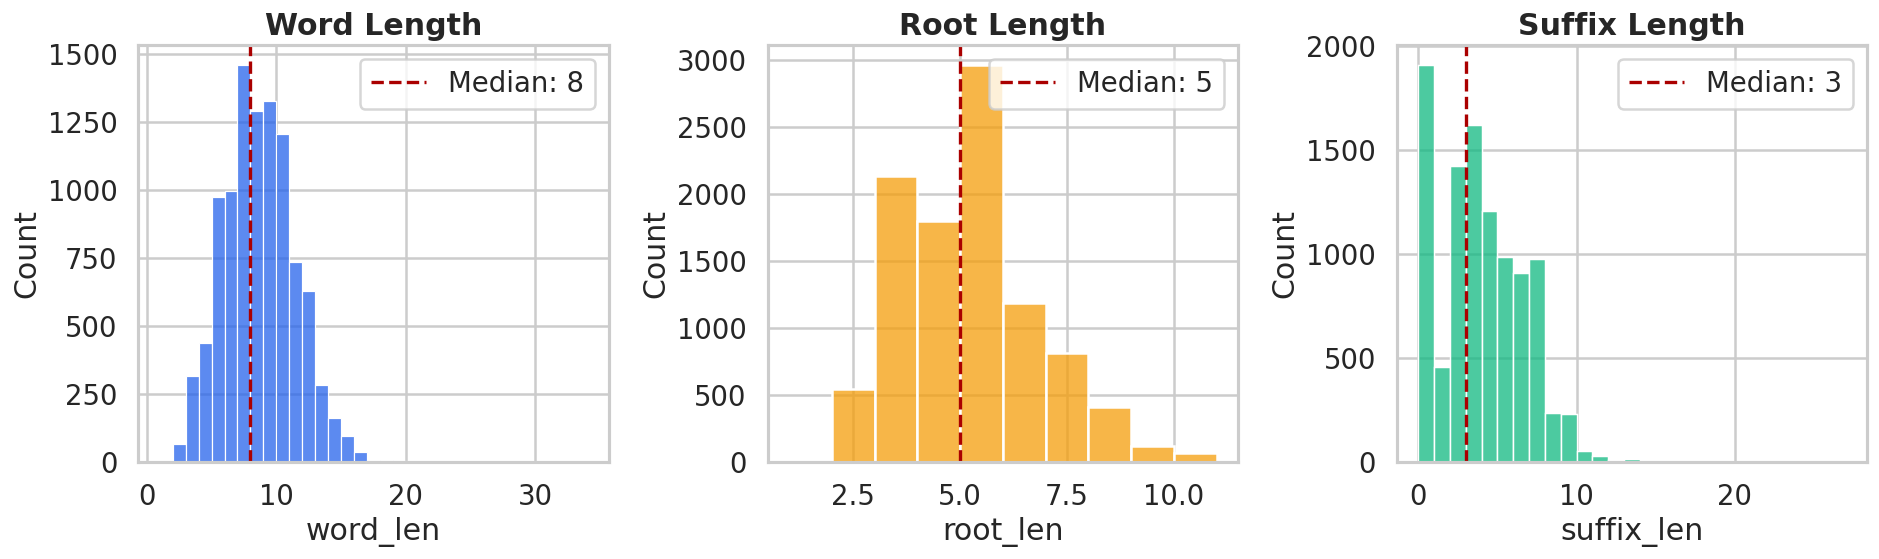

In [7]:
def describe_lengths(series, label):
	desc = series.describe(percentiles=[0.25, 0.5, 0.75])
	print(f"{label} length stats:\n{desc}\n")

print("=== Length statistics ===\n")
describe_lengths(df['word_len'], "Word")
describe_lengths(df['root_len'], "Root")
describe_lengths(df['suffix_len'], "Suffix")

# Histograms (bin width = 1, median line)
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
ax1 = sns.histplot(df['word_len'], binwidth=1, kde=False, color="#2563eb", edgecolor="white")
plt.title("Word Length")
median_vline(ax1, df['word_len'])

plt.subplot(1,3,2)
ax2 = sns.histplot(df['root_len'], binwidth=1, kde=False, color="#f59e0b", edgecolor="white")
plt.title("Root Length")
median_vline(ax2, df['root_len'])

plt.subplot(1,3,3)
ax3 = sns.histplot(df['suffix_len'], binwidth=1, kde=False, color="#10b981", edgecolor="white")
plt.title("Suffix Length")
median_vline(ax3, df['suffix_len'])
plt.tight_layout()
plt.show()

##  **No-Suffix Words and Suffix-Length Buckets (Pie Chart)**

=== Suffix length buckets ===

Bucket counts:
 suffix_bucket
0     1908
1      454
2     1423
3     1619
4+    4623
Name: count, dtype: int64 

No-suffix (NaN/empty) word count: 1908
No-suffix ratio: 19.03%



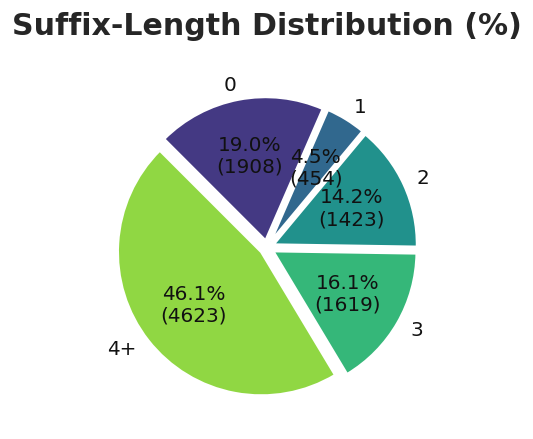

In [8]:
print("=== Suffix length buckets ===\n")
def bucket_suffix_len(n):
	if n == 0:
		return "0"
	if n == 1:
		return "1"
	if n == 2:
		return "2"
	if n == 3:
		return "3"
	return "4+"

df['suffix_bucket'] = df['suffix_len'].apply(bucket_suffix_len)
bucket_counts = df['suffix_bucket'].value_counts().reindex(["0","1","2","3","4+"], fill_value=0)
print("Bucket counts:\n", bucket_counts, "\n")
print(f"No-suffix (NaN/empty) word count: {bucket_counts['0']}")
print(f"No-suffix ratio: {bucket_counts['0'] / len(df):.2%}\n")

colors = sns.color_palette("viridis", n_colors=5)
plt.figure(figsize=(4,4))
plt.pie(
	bucket_counts.values,
	labels=bucket_counts.index,
	colors=colors,
	startangle=135,
	counterclock=False,
	explode=[0.05, 0.05, 0.05, 0.05, 0.05],
	shadow=False,
	autopct=autopct_counts(bucket_counts.values),
	textprops={"color":"#111", "fontsize":12}
)
plt.title("Suffix-Length Distribution (%)", pad=20)
plt.tight_layout()
plt.show()

##  **Frequencies: Visualization of Top Roots and Suffixes**

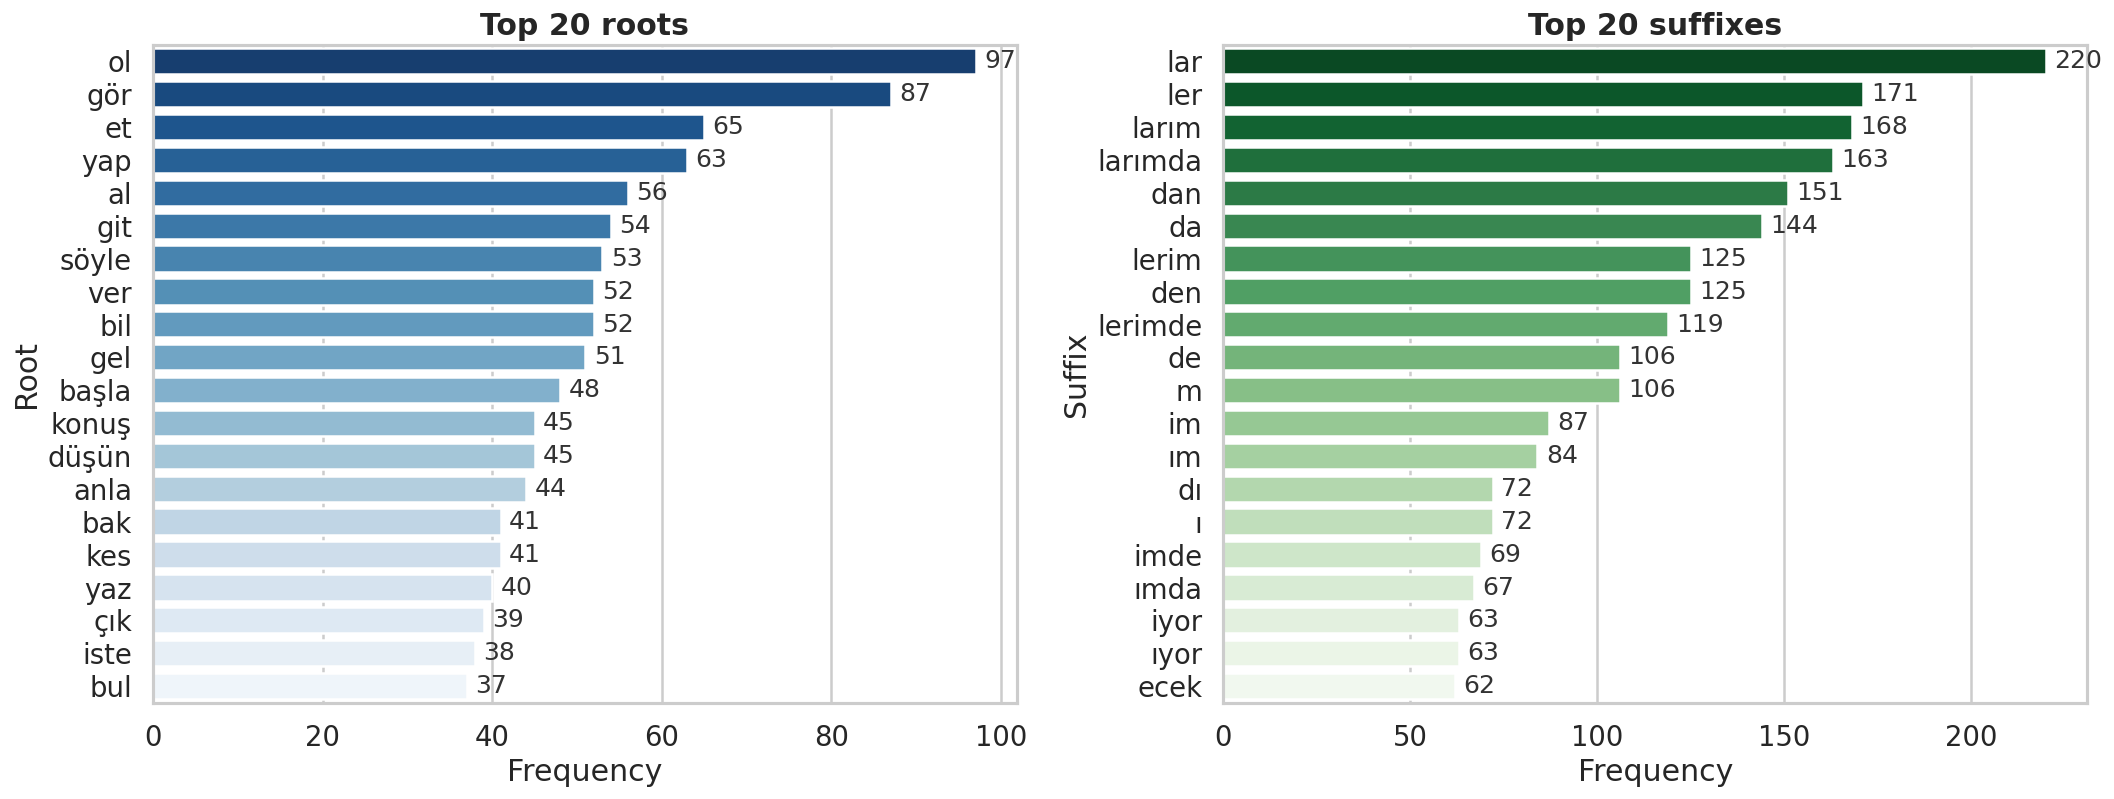

In [9]:
top_n = 20

root_freq = df['root'].value_counts().head(top_n)
suffix_freq = df['suffixes'].dropna().value_counts().head(top_n)

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
ax = sns.barplot(y=root_freq.index, x=root_freq.values, palette="Blues_r")
plt.title(f"Top {top_n} roots")
plt.xlabel("Frequency")
plt.ylabel("Root")
annotate_bars(ax)

plt.subplot(1,2,2)
ax = sns.barplot(y=suffix_freq.index, x=suffix_freq.values, palette="Greens_r")
plt.title(f"Top {top_n} suffixes")
plt.xlabel("Frequency")
plt.ylabel("Suffix")
annotate_bars(ax)

plt.tight_layout()
plt.show()

# **Settings / Hyperparameters**

In [10]:
DATA_PATH = "/kaggle/input/turkish-words/turkish-words-roots-suffixes.csv"
START_TOKEN = "<"
END_TOKEN = ">"
PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
EMBED_DIM = 128
NUM_HEADS = 4
KEY_DIM = EMBED_DIM // NUM_HEADS
FF_DIM = 512
DROPOUT_RATE = 0.1
EPOCHS = 50
BATCH_SIZE = 64
RANDOM_STATE = 42
LABEL_SMOOTHING = 0.1
BEAM_SIZE = 3
CHECKPOINT_WEIGHTS = "best_rootfinder.weights.h5"


# **Preprocessing**

In [11]:
# Load data again
df = pd.read_csv(DATA_PATH)
df = df.dropna(subset=["word", "root"]).reset_index(drop=True)
df = df.drop_duplicates(subset=['word','root','suffixes'], keep='first').reset_index(drop=True)
df["word"] = df["word"].astype(str)
df["root"] = df["root"].astype(str)
df["input"] = df["word"]
df["target_raw"] = df["root"]
df["target"] = df["target_raw"].apply(lambda r: START_TOKEN + r + END_TOKEN)

print("Sample data:")
print(df.head())
print("\n\nInfo about dataset:")
print(df.info())

Sample data:
         word     root suffixes       input target_raw     target
0    alıyorum       al   ıyorum    alıyorum         al       <al>
1      görmek      gör      mek      görmek        gör      <gör>
2      dersin     ders       in      dersin       ders     <ders>
3    şiddetli   şiddet       li    şiddetli     şiddet   <şiddet>
4  yumurtalar  yumurta      lar  yumurtalar    yumurta  <yumurta>


Info about dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9154 entries, 0 to 9153
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   word        9154 non-null   object
 1   root        9154 non-null   object
 2   suffixes    7636 non-null   object
 3   input       9154 non-null   object
 4   target_raw  9154 non-null   object
 5   target      9154 non-null   object
dtypes: object(6)
memory usage: 429.2+ KB
None


##  **Character-Level Vocabulary and Tokenization**

In [12]:
# Build character-level vocab
all_chars = sorted(set(''.join(df["input"].values) + ''.join(df["target"].values)))

# Initialize char-to-index and index-to-char dictionaries with PAD and UNK tokens
char2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1}
idx2char = {0: PAD_TOKEN, 1: UNK_TOKEN}
for i, ch in enumerate(all_chars, start=2):
    char2idx[ch] = i
    idx2char[i] = ch
vocab_size = len(char2idx)

# Tokenizer function: converts a string into a list of token IDs, with padding/truncation
def tokenize_to_ids(text, maxlen):
    ids = [char2idx.get(ch, char2idx[UNK_TOKEN]) for ch in text]
    if len(ids) > maxlen:
        ids = ids[:maxlen]
    else:
        ids += [char2idx[PAD_TOKEN]] * (maxlen - len(ids))
    return ids

# Determine maximum sequence lengths for encoder and decoder
max_encoder_len = df["input"].apply(len).max()
max_decoder_len = df["target"].apply(len).max()
print("Max encoder length:", max_encoder_len)
print("Max decoder length:", max_decoder_len)

# Example
example_word = df["input"][0]
example_target = df["target"][0]
print("\nExample word:", example_word)
print("Tokenized:", tokenize_to_ids(example_word, max_encoder_len))
print("Example target:", example_target)
print("Tokenized target:", tokenize_to_ids(example_target, max_decoder_len))

Max encoder length: 34
Max decoder length: 13

Example word: alıyorum
Tokenized: [4, 15, 33, 27, 18, 21, 24, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Example target: <al>
Tokenized target: [2, 4, 15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
all_chars

['<',
 '>',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'y',
 'z',
 'ç',
 'ö',
 'ü',
 'ğ',
 'ı',
 'ş']

In [14]:
char2idx

{'<PAD>': 0,
 '<UNK>': 1,
 '<': 2,
 '>': 3,
 'a': 4,
 'b': 5,
 'c': 6,
 'd': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'h': 11,
 'i': 12,
 'j': 13,
 'k': 14,
 'l': 15,
 'm': 16,
 'n': 17,
 'o': 18,
 'p': 19,
 'q': 20,
 'r': 21,
 's': 22,
 't': 23,
 'u': 24,
 'v': 25,
 'w': 26,
 'y': 27,
 'z': 28,
 'ç': 29,
 'ö': 30,
 'ü': 31,
 'ğ': 32,
 'ı': 33,
 'ş': 34}

##  **Data Preparation for Seq2Seq**

In [15]:
# Encode input words: tokenize each input word and pad/truncate to max_encoder_len
encoder_input = np.array([tokenize_to_ids(w, max_encoder_len) for w in df["input"]], dtype=np.int32)

# Prepare decoder inputs and targets for teacher forcing
decoder_input_list = []
decoder_target_list = []
for t in df["target"]:
    dec_in = t[:-1]
    dec_tgt = t[1:]
    decoder_input_list.append(tokenize_to_ids(dec_in, max_decoder_len))
    decoder_target_list.append(tokenize_to_ids(dec_tgt, max_decoder_len))

decoder_input = np.array(decoder_input_list, dtype=np.int32)
decoder_target = np.array(decoder_target_list, dtype=np.int32)

# Split
words = df["input"].values
roots = df["target_raw"].values

(X_train_enc, X_val_enc,
 X_train_dec, X_val_dec,
 y_train, y_val,
 words_train, words_val,
 roots_train_raw, roots_val_raw) = train_test_split(
    encoder_input, decoder_input, decoder_target, words, roots,
    test_size=0.1, random_state=RANDOM_STATE
)

print("Encoder input shape:", X_train_enc.shape)
print("Decoder input shape:", X_train_dec.shape)

# Example
print("\nExample word:", example_word)
print("Encoder Input:", encoder_input[0])
print("Decoder Input:", decoder_input[0])
print("Decoder Target:", decoder_target[0])

Encoder input shape: (8238, 34)
Decoder input shape: (8238, 13)

Example word: alıyorum
Encoder Input: [ 4 15 33 27 18 21 24 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
Decoder Input: [ 2  4 15  0  0  0  0  0  0  0  0  0  0]
Decoder Target: [ 4 15  3  0  0  0  0  0  0  0  0  0  0]


# **Transformer Model**

In [16]:
# Inputs
encoder_inputs = Input(shape=(max_encoder_len,), dtype="int32", name="encoder_inputs")
decoder_inputs = Input(shape=(max_decoder_len,), dtype="int32", name="decoder_inputs")

# Shared embedding
embedding = Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, mask_zero=True, name="char_embedding")
enc_emb = embedding(encoder_inputs)
dec_emb = embedding(decoder_inputs)

# Positional embeddings
pos_enc = Embedding(input_dim=max_encoder_len, output_dim=EMBED_DIM, name="pos_enc")
pos_dec = Embedding(input_dim=max_decoder_len, output_dim=EMBED_DIM, name="pos_dec")
enc_positions = tf.range(start=0, limit=max_encoder_len, delta=1)
dec_positions = tf.range(start=0, limit=max_decoder_len, delta=1)
enc_emb = enc_emb + pos_enc(enc_positions)
dec_emb = dec_emb + pos_dec(dec_positions)

# Encoder mask
enc_bool_mask = Lambda(lambda x: tf.not_equal(x, 0), name="enc_bool_mask")(encoder_inputs)
enc_attn_mask = Lambda(lambda m: tf.expand_dims(m, axis=1), name="enc_attn_mask")(enc_bool_mask)

# Decoder causal + padding mask
def make_decoder_mask(x):
    dec_pad = tf.not_equal(x, 0)
    dec_pad_1 = tf.expand_dims(dec_pad, -1)
    dec_pad_2 = tf.expand_dims(dec_pad, 1)
    causal = tf.linalg.band_part(tf.ones((max_decoder_len, max_decoder_len), dtype=tf.bool), -1, 0)
    causal = tf.expand_dims(causal, 0)
    return tf.logical_and(tf.logical_and(dec_pad_1, dec_pad_2), causal)

dec_combined_mask = Lambda(make_decoder_mask, name="dec_combined_mask")(decoder_inputs)

# --- Encoder stack ---
enc_x = enc_emb
for layer_idx in range(NUM_ENCODER_LAYERS):
    # Self-attention
    enc_self_attn = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, dropout=DROPOUT_RATE, name=f"enc_mha_{layer_idx}")
    attn_out = enc_self_attn(query=enc_x, value=enc_x, key=enc_x, attention_mask=enc_attn_mask)
    attn_out = Dropout(DROPOUT_RATE)(attn_out)
    enc_x = LayerNormalization(epsilon=1e-6)(attn_out + enc_x)

    # Feed-forward
    enc_ffn = Sequential([
        Dense(FF_DIM, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(EMBED_DIM),
    ], name=f"enc_ffn_{layer_idx}")
    ffn_out = enc_ffn(enc_x)
    enc_x = LayerNormalization(epsilon=1e-6)(ffn_out + enc_x)

enc_final = enc_x

# --- Decoder stack ---
x = dec_emb
for layer_idx in range(NUM_DECODER_LAYERS):
    # Masked self-attention
    self_attn = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, dropout=DROPOUT_RATE, name=f"dec_self_attn_{layer_idx}")
    sa_out = self_attn(query=x, value=x, key=x, attention_mask=dec_combined_mask)
    sa_out = Dropout(DROPOUT_RATE)(sa_out)
    sa_out = LayerNormalization(epsilon=1e-6)(sa_out + x)

    # Cross-attention
    cross_attn = MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, dropout=DROPOUT_RATE, name=f"dec_cross_attn_{layer_idx}")
    ca_out = cross_attn(query=sa_out, value=enc_final, key=enc_final, attention_mask=enc_attn_mask)
    ca_out = Dropout(DROPOUT_RATE)(ca_out)
    ca_out = LayerNormalization(epsilon=1e-6)(ca_out + sa_out)

    # Feed-forward
    ffn = Sequential([
        Dense(FF_DIM, activation="relu"),
        Dropout(DROPOUT_RATE),
        Dense(EMBED_DIM),
    ], name=f"dec_ffn_{layer_idx}")
    ffn_out = ffn(ca_out)
    x = LayerNormalization(epsilon=1e-6)(ffn_out + ca_out)

# Output projection
final_probs = Dense(vocab_size, activation="softmax", name="final_softmax")(x)

model = tf.keras.Model([encoder_inputs, decoder_inputs], final_probs)
model.summary()


I0000 00:00:1756914481.578854      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756914481.579594      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_bool_mask       │ (None, 34)        │          0 │ encoder_inputs[0… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embedding      │ (None, 13, 128)   │      4,480 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_attn_mask       │ (None, 1, 34)     │          0 │ enc_bool_mask[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 34, 128)   │          0 │ char_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_mha_0           │ (None, 34, 128)   │     66,048 │ enc_attn_mask[0]… │
│ (MultiHeadAttentio… │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0],        │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 128)   │          0 │ enc_mha_0[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 34, 128)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 34, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_ffn_0           │ (None, 34, 128)   │    131,712 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 34, 128)   │          0 │ enc_ffn_0[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 34, 128)   │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_mha_1           │ (None, 34, 128)   │     66,048 │ enc_attn_mask[0]… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 34, 128)   │          0 │ enc_mha_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 34, 128)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 934,691 (3.57 MB)

 Trainable params: 934,691 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

##  **Loss Function and Model Compilation**

In [17]:
pad_id = char2idx[PAD_TOKEN]

# Convert vocab size to float for smoothing calculation
vocab_size_f = tf.cast(vocab_size, tf.float32)
smooth = float(LABEL_SMOOTHING)

def sparse_smoothed_cce(y_true, y_pred):
    """
    Computes sparse categorical cross-entropy with label smoothing and ignores padding tokens.
    
    Args:
        y_true: true token IDs, shape (batch_size, seq_len)
        y_pred: predicted probabilities, shape (batch_size, seq_len, vocab_size)
    
    Returns:
        Scalar loss averaged over non-padding tokens.
    """
    y_true = tf.cast(y_true, tf.int32)
    mask = tf.cast(tf.not_equal(y_true, pad_id), tf.float32)
    y_true_oh = tf.one_hot(y_true, depth=vocab_size)
    y_smoothed = y_true_oh * (1.0 - smooth) + (smooth / vocab_size_f)
    loss_per_token = tf.keras.losses.categorical_crossentropy(y_smoothed, y_pred, from_logits=False)
    loss_per_token = loss_per_token * mask
    denom = tf.reduce_sum(mask) + 1e-8
    return tf.reduce_sum(loss_per_token) / denom

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss=sparse_smoothed_cce,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy")]
)


##  **Model Training and Callbacks**

In [18]:
# --- Checkpoint callback ---
checkpoint = ModelCheckpoint(
    CHECKPOINT_WEIGHTS,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min",
    verbose=1
)

# --- Early stopping callback ---
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True,
    verbose=1
)

# --- Reduce learning rate on plateau ---
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# --- LR logger callback: logs the optimizer's learning rate at the end of each epoch ---
class LrLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.lrs.append(lr)

lr_logger = LrLogger()

# --- Combine all callbacks ---
callbacks = [checkpoint, early_stop, reduce_lr, lr_logger]

# --- Model training ---
history = model.fit(
    [X_train_enc, X_train_dec],
    y_train,
    validation_data=([X_val_enc, X_val_dec], y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=2
)

# --- Save the trained model ---
model.save("final_rootfinder_model.h5")

Epoch 1/50


I0000 00:00:1756914504.007098      67 service.cc:148] XLA service 0x7b0fe8014b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756914504.007879      67 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756914504.007899      67 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756914505.912353      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756914518.769673      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.89171, saving model to best_rootfinder.weights.h5
129/129 - 55s - 427ms/step - loss: 1.5682 - sparse_categorical_accuracy: 0.3114 - val_loss: 0.8917 - val_sparse_categorical_accuracy: 0.4091 - learning_rate: 5.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.89171 to 0.83201, saving model to best_rootfinder.weights.h5
129/129 - 2s - 14ms/step - loss: 0.8675 - sparse_categorical_accuracy: 0.4127 - val_loss: 0.8320 - val_sparse_categorical_accuracy: 0.4185 - learning_rate: 5.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.83201 to 0.81434, saving model to best_rootfinder.weights.h5
129/129 - 2s - 14ms/step - loss: 0.8227 - sparse_categorical_accuracy: 0.4186 - val_loss: 0.8143 - val_sparse_categorical_accuracy: 0.4188 - learning_rate: 5.0000e-04
Epoch 4/50

Epoch 4: val_loss improved from 0.81434 to 0.80544, saving model to best_rootfinder.weights.h5
129/129 - 2s - 14ms/step - loss: 0.7991 - sparse_categorical_accuracy: 0.4225 - val_

# **Visualization: Loss, Accuracy, Learning Rate**

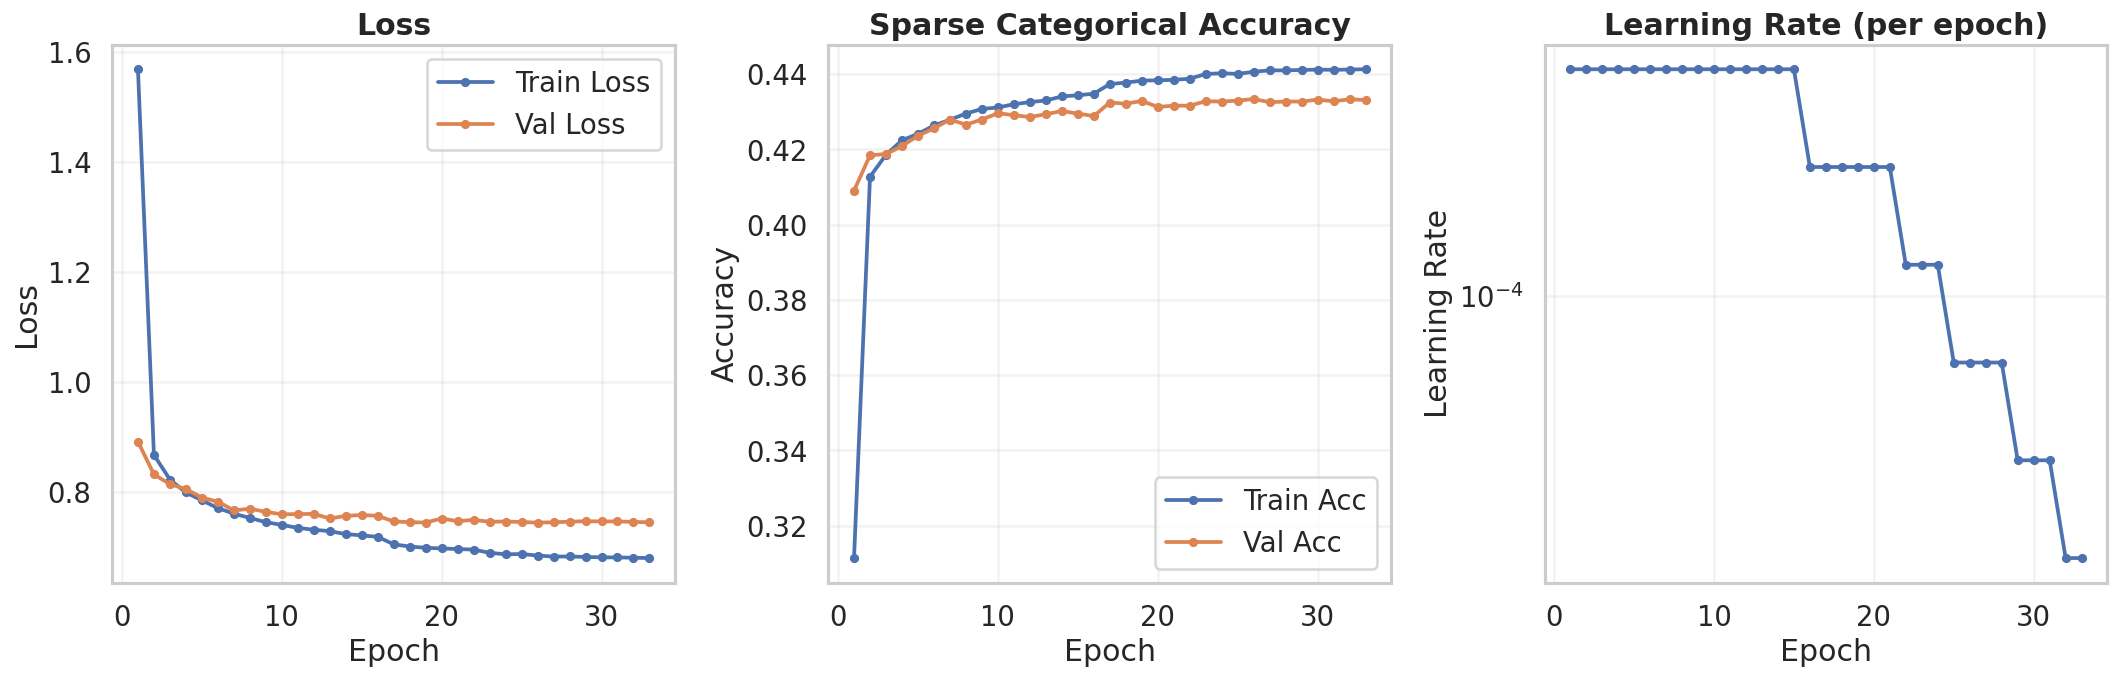

In [19]:
epochs = range(1, len(history.history["loss"]) + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) Loss (train & val)
axes[0].plot(epochs, history.history["loss"], label="Train Loss", marker='.')
if "val_loss" in history.history:
    axes[0].plot(epochs, history.history["val_loss"], label="Val Loss", marker='.')
axes[0].set_title("Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(alpha=0.25)

# 2) Accuracy (sparse_categorical_accuracy)
acc_key = "sparse_categorical_accuracy"
val_acc_key = "val_" + acc_key
if acc_key in history.history:
    axes[1].plot(epochs, history.history[acc_key], label="Train Acc", marker='.')
if val_acc_key in history.history:
    axes[1].plot(epochs, history.history[val_acc_key], label="Val Acc", marker='.')
axes[1].set_title("Sparse Categorical Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(alpha=0.25)

# 3) Learning rate (Saved by lr_logger)
# The length of lr_logger.lrs should be equal to the number of epochs recorded during training
lrs = getattr(lr_logger, "lrs", None)
if lrs is None or len(lrs) == 0:
    current_lr = float(tf.keras.backend.get_value(model.optimizer.lr))
    lrs = [current_lr] * len(epochs)
axes[2].plot(epochs, lrs, marker='.')
axes[2].set_title("Learning Rate (per epoch)")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Learning Rate")
axes[2].set_yscale("log")
axes[2].grid(alpha=0.25)

plt.tight_layout()
plt.show()

# **Load best weights from checkpoint**

In [20]:
if os.path.exists(CHECKPOINT_WEIGHTS):
    try:
        model.load_weights(CHECKPOINT_WEIGHTS)
        print("Loaded best weights from checkpoint.")
    except Exception as e:
        print("Could not load checkpoint weights:", e)


Loaded best weights from checkpoint.


# **Root Prediction Functions (Greedy and Beam Search)**

In [21]:
# Greedy
def predict_root_greedy(word, max_len=max_decoder_len):
    enc_seq = np.array([tokenize_to_ids(word, max_encoder_len)], dtype=np.int32)
    dec_seq = np.zeros((1, max_len), dtype=np.int32)
    start_id = char2idx.get(START_TOKEN, char2idx[UNK_TOKEN])
    dec_seq[0, 0] = start_id
    result_chars = []
    for i in range(0, max_len - 1):
        preds = model.predict([enc_seq, dec_seq], verbose=0)
        next_id = int(np.argmax(preds[0, i, :]))
        if next_id == pad_id: break
        next_char = idx2char.get(next_id, "")
        if next_char == END_TOKEN: break
        if next_char not in (START_TOKEN, PAD_TOKEN, UNK_TOKEN):
            result_chars.append(next_char)
        dec_seq[0, i + 1] = next_id
    return "".join(result_chars)

# Beam search
def beam_search_decode(model, word, beam_size=BEAM_SIZE, max_len=max_decoder_len):
    enc_seq = np.array([tokenize_to_ids(word, max_encoder_len)], dtype=np.int32)
    start_id = char2idx.get(START_TOKEN, char2idx[UNK_TOKEN])
    end_id = char2idx.get(END_TOKEN, None)
    init_dec = np.zeros((1, max_len), dtype=np.int32)
    init_dec[0, 0] = start_id
    hyps = [(init_dec, 0.0, False)]

    for t in range(0, max_len - 1):
        all_candidates = []
        dec_batch = np.concatenate([h[0] for h in hyps], axis=0)
        enc_batch = np.repeat(enc_seq, repeats=len(hyps), axis=0)
        preds = model.predict([enc_batch, dec_batch], verbose=0)

        for i, (dec_arr, score, finished) in enumerate(hyps):
            if finished: all_candidates.append((dec_arr.copy(), score, True)); continue
            probs = preds[i, t, :]
            probs = np.clip(probs, 1e-12, 1.0)
            log_probs = np.log(probs)
            top_ids = np.argpartition(-log_probs, beam_size)[:beam_size]
            top_ids = top_ids[np.argsort(-log_probs[top_ids])]
            for tok in top_ids:
                new_dec = dec_arr.copy()
                new_dec[0, t + 1] = int(tok)
                new_score = score + float(log_probs[tok])
                new_finished = (int(tok) == end_id) if end_id is not None else False
                all_candidates.append((new_dec, new_score, new_finished))

        all_candidates.sort(key=lambda x: x[1], reverse=True)
        hyps = all_candidates[:beam_size]
        if all(h[2] for h in hyps): break

    best_dec, _, _ = max(hyps, key=lambda x: x[1])
    result_chars = []
    for idx in best_dec[0, 1:]:
        if int(idx) == pad_id: break
        ch = idx2char.get(int(idx), "")
        if ch == END_TOKEN: break
        if ch not in (START_TOKEN, PAD_TOKEN, UNK_TOKEN): result_chars.append(ch)
    return "".join(result_chars)


# **Model Testing with Sample Words**

In [22]:
test_words = [
    "evimdeyken", "kitapta", "görüyordum", "koşacaklarmış",
    "bulutlardayım", "tevekkül", "cömert", "etkilendim",
    "önderimiz", "anlamlandıramadıklarımdan"
]

print("\nGreedy predictions:")
for w in test_words:
    word_norm = w.casefold()
    print(w, "→", predict_root_greedy(word_norm))

print("\nBeam search predictions (beam_size={}):".format(BEAM_SIZE))
for w in test_words:
    word_norm = w.casefold()
    print(w, "→", beam_search_decode(model, word_norm, beam_size=BEAM_SIZE))



Greedy predictions:
evimdeyken → ev
kitapta → kitap
görüyordum → gör
koşacaklarmış → koş
bulutlardayım → bulut
tevekkül → tevekkül
cömert → cömert
etkilendim → etkilen
önderimiz → önder
anlamlandıramadıklarımdan → anlamlan

Beam search predictions (beam_size=3):
evimdeyken → ev
kitapta → kitap
görüyordum → gör
koşacaklarmış → koş
bulutlardayım → bulut
tevekkül → tevekkül
cömert → cömert
etkilendim → etkilen
önderimiz → önder
anlamlandıramadıklarımdan → anlamlan
